# Intro

**대회 개요**

- 3축 가속도계(accelerometer)와 3축 자이로스코프(gyroscope)를 활용해 측정된 센서 데이터에 머신러닝 알고리즘을 적용해 운동 동작 인식 알고리즘 개발
- 심사 기준: LogLoss
- 1차 평가(Public Score): 테스트 데이터 중 랜덤 샘플 된 50%로 채점, 대회 기간 중 공개
- 2차 평가(Private Score): 나머지 50 % 테스트 데이터로 채점, 대회 종료 직후 공개


-------------

**데이터**
1. 3축 가속도계(accelerometer)와 3축 자이로스코프(gyroscope)를 활용해 측정된 센서 데이터

2. 한 개의 행은 0.02초 (second)를 의미합니다. 즉 하나의 id 에 대해서 600개의 time 이 존재하므로  총 12초(0.02*600)동안의 동작을 측정한 것입니다.

3. 이 때에 가속계와, 자이로스코프는 오른쪽 forearm(전완) 에 착용하여 측정한 데이터입니다.
4. 가속도계는 해당 방향으로의 가속도(g)를, 자이로스코프는 해당 방향으로의 dps(degrees per second)를 측정한 것입니다.


- **train_features.csv (1875000, 8)**

    id 별 600 time 간 동작 데이터
    
    id 3125개 x 600 time =1875000 데이터


- **train_labels.csv (3125, 3)**

    id 별 동작과 동작 label(61개)


- **test_features.csv (469200, 8)**

    id 별 600 time간 동작 데이터
    
    id 782개 x 600 time =469200 데이터


- **sample_submission.csv (782, 62)**

    id별 동작을 예측해 작성하는 csv


-------------------

**EDA ISSUE**

- 데이터는 그 측정 간격이 매우 좁아서 진동이 심했다. 
    - 이런 자잘한 진동은 크게 도움이 되지 않을것이라 판단해 3이동평균으로 Smoothing 한 데이터와 30이동평균한 데이터와 같이 EDA 진행

- 측정기가 오른속 전완근에 붙여져 있다는 점에서 격렬한 운동시에 부착된 기계가 돌아가면서(땀으로 인해) x,y,z 축을 제대로 측정하지 못했다.
    - 이는 동일한 운동에 대해 x,y,z 축이 다른 acc 값으로 측정되어있다는 점에서 알 수 있었다.
    - 그리고 플랭크, pushup, 등의 운동을 고려할 때에 x축의 측정 방향이 손목쪽이라는것을 캐치하였다.
    - 손목쪽으로 측정되는 값은 격렬한 운동에도 크게 변하지 않으므로 매우 중요할것이라 생각하고 이를 중심으로 EDA 진행

- 사용자에 따라 그 측정의 acc,gy 가 각기 달랐다.
    - 이는 같은 운동임에도 사용자별로 가동범위가 달라서 gy 가 달라지고 힘이 달라서 acc가 달라지기 때문이였다.
    - acc 의 경우는 percentile(0.75) 값으로 Normalizing 한다던가 조치가 가능하였으나 gy 의 경우 '가동 범위' 였기 떄문에 생각보다는 큰 차이가 없을거라 판단하고 그대로 진행
    
- 데이터가 심하게 Imbalance 되어있다.
    - Non exercise 는 1500개 남짓인데 반해, 제일 적은 label 의 경우 14개밖에 되지 않았다.
    - weight 를 다르게 한다던가, Upsampling 을 진행해서 막아보려 했다. (다만 선택된 모델에 대해서는 그 효과가 없었다.)

- sample size 에 비해 운동종류가 너무 많다.(61가지)
    - 데이콘에서 제공하는 링크에 들어가보니, 그곳에서는 95%의 정확성을 달성했다고 나왔다.
    - 하지만 이는 '매우 많은' 데이터를 통해 얻은 정확성일 것이다. 그 경우에도 간신히 95%를 달성한것.
    - 내가 눈으로 봐도 절대 구분하지 못할 운동의 종류가 있었다.
    - 위를 종합했을때에 모델 정확성의 상한선은 85%정도라고 판단하였음
    - Public score 에 매몰되어 오히려 그 score 에 과적합되어서 private score 에서 낮은 순위를 얻는 과오를 범하지 않기 위해 public 값은 10% 안에만 드는것으로 하고 최대한 ROBUST 하게 진행
    
- acc 의 경우 '중력값' 이 더해져있기 때문에 정확한 측정이 어려움
    - 중력값은 1로 추정된다.
    - 중력값이 각 방향으로 분산되어 더해져있기 떄문에 이 역시 오차의 원인이 되었다.


---

**EDA**

최대한 각종 운동들을 엄청나게 살펴보면서 어떤 measure 을 통해서 이 운동들을 분류할 수 있을지를 생각함 <br>
그렇게 고민한 결과 총 7가지의 EDA 를 실시하였으며 그에 따라서 28개의 변수를 추출함 <br>
이 이상 추출하는것은 모델에 도움이 안되고, 과적합의 ISSUE 가 있기때문에 여기서 멈춤 <br>



---

**시행해 본 모델**

- LSTM : Dropout 0.2 를 적용한 단층 LSTM
    - Validation 이 0.9부근에서 좋아지지 않음

- Multi layer LSTM : 2~3 층 Dropout 0.2 를 적용
    - 0.8~0.9 수준 어느정도는 개선된 모습

- Bidirectional LSTM : 1~2층 Dropout 0.2 적용
    - 0.8 수준
    - validation loss 가 매우 빠르게 줄어 10epoch 내로 0.9~0.8 까지 떨어짐

- GRU : 위와 같이 Bidirectional,Multi 모두 적용해 보앗음
    - 0.7후반 ~ 0.9 수준  
    - LSTM 보다 적합속도가 빠르고 성능이 약간 더 좋았음
    
- Multi route LSTM(GRU)
    - 데이터에서 ID 별로 최소, 최대값, 평균, Noise 등 뽑아낼 수 있는 좋은 정보들을 뽑아내었을 때에, 이 정보를 마냥 LSTM 에 넣을 수 없다는 생각에서 출발
    - 뽑은 정보들은 다른 길을 통해서 LSTM 의 출력값(32~64개의 OUTPUT)과 다이렉트로 합쳐지게 만듦
    - 즉 시계열 정보는 LSTM(GRU) 를 지나가면서 고려가 되고, 유용한 정보는 추가적으로 따로 만든 길을 통해 LSTM 을 거치지 않고 바로 이용할 수 있도록 만듦
    - LSTM 의 출력값과 우리가 직접 구한 요약치가 합쳐지고 난 이후에는 NN 모델로 1~2 층의 relu 를 쌓음
    - 노력에 비해 Validation 값은 0.9~1.1 수준

- LSTM(GRU)model + Upsampling(np.roll)
    - 주어진 데이터가 12초간의 짧은 '주기를' 가진 데이터 임을 이용
    - 즉 랜덤으로 데이터의 끝 부분을 잘라 앞에 붙이는 방식으로 Upsampling 을 진행
    - 하지만 이 경우에도 과적합이 해결되지 않았음 (0.8~1.0) 

- XGboost + Upsampling(imblearn의 ADASYN)
    - 회귀의 경우 Upsampling 을 하였을 때에가 늘 성능이 더 좋았다.
    - 각 가지마다 분기되는 최소 sample 수를 제한할 떄 성능이 매우 좋았음
    - 적합을 여러번 해 본 결과, 원래 수준에서는 100개 남짓으로 제한하는것이 성능이 좋았다.
    - 0.7 ~ 0.8
    
- lgbm + Upsampling(imblearn의 ADASYN)
    - 위 xgboost 와 같음. 
    - 0.7 ~ 0.6 후반

- DNN 모델(relu..)
    - 위처럼 lstm,gru 처럼 시간의 흐름을 고려하는 모델이 아니라 그냥 다층의 DNN 을 사용
    - lgbm,xgboost 도 적합속도가 느리고 LSTM 등의 모델은 더욱 느린데에다 렘을 너무 먹어 코랩이 중단되기 일수였다.
    - 하지만 그냥 쌓은 DNN 모델은 적합속도가 빠르고 또한 성능이 준수하여 이 모델을 집중적으로 훈련하기 시작
    - 다만 Upsampling methods 가 모두 안좋게 나와서 과적합이 심히 우려된다.
    - 0.6 초중반 
    

# Setting

In [2]:
# 모델 형성시 필요한 모듈
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization,GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
import scipy
from scipy.signal import find_peaks

from platform import python_version

np.random.seed(42)
random.seed(42)

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 100)
#warnings.filterwarnings('ignore')

train=pd.read_csv('./data/train_features.csv')
train_labels=pd.read_csv('./data/train_labels.csv')
test=pd.read_csv('./data/test_features.csv')
submission=pd.read_csv('./data/sample_submission.csv')

In [3]:
print('tensor version :', tf.__version__)     
print('keras version :', keras.__version__)
print('sklearn version :', sklearn.__version__)
print('numpy version :', np.__version__)
print('pandas version :', pd.__version__)
print('scipy version :', scipy.__version__)

tensor version : 2.1.0
keras version : 2.2.4-tf
sklearn version : 0.24.1
numpy version : 1.19.1
pandas version : 1.1.1
scipy version : 1.5.2


- 내가 만든 변수들을 운동 종목별로 나누어 보는 함수

In [6]:
def whole_table(ex,train_labels):
    df_ex = pd.DataFrame()
    for exer in train_labels['label_desc'].sort_values().unique() :
        val = np.mean(ex.iloc[train_labels[train_labels['label_desc'] == exer]['id'],:],axis=0)
        df_ex = pd.concat([df_ex,pd.DataFrame(val,columns=[exer])],axis=1)
    return df_ex

- 운동별(exer) 각 element 들의 변수 확인

In [5]:
def each_table(ex,train_labels,exer):
    each = ex.iloc[train_labels[train_labels['label_desc'] == exer]['id'],:].T
    return each

In [7]:
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [8]:
#test'id'는 782개 
test['id'].nunique()

782

In [9]:
train_labels['label_desc'].unique()

array(['Shoulder Press (dumbbell)', 'Non-Exercise', 'Biceps Curl (band)',
       'Side Plank Right side', 'Plank', 'Chest Press (rack)',
       'Wall Squat', 'Russian Twist', 'Running (treadmill)',
       'Pushup (knee or foot variation)', 'Wall Ball',
       'Dynamic Stretch (at your own pace)',
       'Sit-up (hands positioned behind head)', 'Tap Right Device',
       'Static Stretch (at your own pace)', 'Device on Table',
       'Triceps extension (lying down)', 'Elliptical machine', 'Burpee',
       'Walking lunge', 'Lateral Raise', 'Jump Rope',
       'Triceps Kickback (knee on bench) (label spans both arms)',
       'Medicine Ball Slam',
       'Lunge (alternating both legs, weight optional)',
       'Fast Alternating Punches', 'Static stretch',
       'Squat Rack Shoulder Press', 'Overhead Triceps Extension',
       'Seated Back Fly', 'Bicep Curl', 'Side Plank Left side',
       'Dumbbell Squat (hands at side)', 'Dumbbell Deadlift Row',
       'Two-arm Dumbbell Curl (both arms, 

In [10]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [12]:
#782개의 id 별 동작 데이터를 활용해 각각의id가 어떤 동작인지를 분류하는 문제
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 데이터 살펴보기

In [13]:
# 너~무나도 불균형한 데이터
train_labels['label_desc'].value_counts()

Non-Exercise                                                1518
Device on Table                                               97
Plank                                                         55
Wall Squat                                                    48
Jump Rope                                                     47
Two-arm Dumbbell Curl (both arms, not alternating)            37
Tap Right Device                                              37
Dip                                                           37
V-up                                                          36
Lunge (alternating both legs, weight optional)                35
Pushup (knee or foot variation)                               35
Shoulder Press (dumbbell)                                     35
Burpee                                                        35
Squat (arms in front of body, parallel to ground)             35
Overhead Triceps Extension                                    34
Sit-up (hands positioned 

In [14]:
#id 별로 각각 600개의 데이터가 있음을 확인   
train['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

- 시각화 하는 부분이나, 이는 61개나 되는 각 운동별 plot 을 그려야해서 여기서는 Skip함

In [15]:
def plot(exercise,df,lis1,lis2) : # 각 운동(exersice) 에 대해서 df set 에 대해 lis1, lis2 에 해당하는 그래프를 그려준다.
    plt.figure(figsize= (25,20))
    plt.subplots_adjust(top = 3)
    for i in range(0,5) :
        plt.subplot(12,2,2*i+1)
        idx = random.choice(list(train_labels[train_labels['label_desc'] == exercise ]['id']))
        plt.plot(df[df['id']==idx].loc[:,lis1])
        plt.legend(lis1)
        plt.title(exercise)
        plt.subplot(12,2,2*i+2)
        plt.plot(df[df['id']==idx].loc[:,lis2])
        plt.legend(lis2)
        plt.title(exercise)

In [16]:
#for i in train_labels['label_desc'].unique() :
#    plot(i,train,['acc_x','acc_y','acc_z'],['gy_x','gy_y','gy_z'])

# EDA

## Noise

- 원래 데이터 - 31 이동평균 데이터 를 뺀 이후에 abs 를 한 이후게 얻은 값
- 이 때에 각 quanile 0.9,0.1 을 normalizing 하여서 그 높낮이 값에 대한 Noise 변화의 증감을 낮췄다.
- 즉 이 값은 순수한 Noise의 크기 합을 나타낸다.

In [18]:
def moving(train):
    df_train = train.copy()
    df_train['index']= df_train.index
    df_train1 = train.loc[:,['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']].groupby(train['id']).rolling(3,center=True).mean().reset_index().drop(columns=['level_1']).dropna().reset_index()
    df_train2 = train.loc[:,['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']].groupby(train['id']).rolling(31,center=True).mean().reset_index().drop(columns=['level_1']).dropna().reset_index()
    df_new = pd.merge(df_train, df_train2, on='index')
    df_new.drop(columns=['id_y','time','index'],inplace = True)
    def quant(x):
        val1 = np.quantile(x,0.9)
        val2 = np.quantile(x,0.1)
        return(val1-val2)
    df_noise= df_new[['acc_x_x', 'acc_y_x', 'acc_z_x', 'gy_x_x', 'gy_y_x', 'gy_z_x']].values - df_new[['acc_x_y', 'acc_y_y', 'acc_z_y', 'gy_x_y', 'gy_y_y', 'gy_z_y']].values
    normalize = df_new.groupby('id_x').agg(quant)[['acc_x_x', 'acc_y_x', 'acc_z_x', 'gy_x_x', 'gy_y_x', 'gy_z_x']].values
    df_noise = pd.DataFrame(df_noise,columns=['noise_acc_x', 'noise_acc_y', 'noise_acc_z', 'noise_gy_x', 'noise_gy_y', 'noise_gy_z'])
    df_noise = pd.concat([df_new['id_x'],df_noise],axis=1)
    df_noise = np.abs(df_noise)
    df_noise = df_noise.groupby('id_x').agg(sum)
    df_noise = df_noise/ normalize
    df = df_noise
    df.reset_index(inplace = True,drop= True)
    return df, df_train, df_train1, df_train2

In [19]:
df,df_train,df_train1,df_train2 = moving(train)

## Local maximum

- train_2 (center 을 True 로 한 이동평균) 데 애해서, local maximum 의 수를 센다.
- 노이즈가 매우 많은 경우 큰 값을 나타나게 된다.

In [20]:
def Local(df,train):    
    def pick(x) :
        val = len(find_peaks(x)[0])
        return val
    ex = train.groupby('id').agg(pick) # id 를 기준으로 한다.
    df_local = ex.iloc[:,1:].reset_index(drop=True)
    df_local.columns = ['local_acc_x', 'local_acc_y', 'local_acc_z', 'local_gy_x', 'local_gy_y', 'local_gy_z']
    df = pd.concat([df,df_local],axis=1)
    return df

In [21]:
df = Local(df,df_train2)
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0


## Diff

- 3 이동평균을 제안한 값에 대하여, 최대값과 최소값의 차이를 조사한다.
- 그럴 경우 큰 차이가 난다면, 가동범위가 매우 크다는것을 의미한다.

In [22]:
def Diff(df, train):
    df_diff = train.groupby('id').max().iloc[:,1:] - train.groupby('id').min().iloc[:,1:]
    df_diff = df_diff.reset_index().iloc[:,1:]
    df_diff.columns = ['dif_acc_x', 'dif_acc_y', 'dif_acc_z', 'dif_gy_x', 'dif_gy_y', 'dif_gy_z']
    df = pd.concat([df,df_diff],axis=1)
    return(df)

In [23]:
df = Diff(df,train)

In [24]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145


## Mean

- mean 은 3 평균을 취한 train1 에서부터 진행하자

In [25]:
def Mean(df,train) :
    df_mean = train.groupby('id').mean().reset_index().iloc[:,2:5]
    df_mean.columns = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z']
    df = pd.concat([df,df_mean],axis=1)
    return(df)

In [26]:
df = Mean(df,df_train1)

In [27]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-0.109792,0.881698,-0.121676


## Dif_Mean

- Dif_Mean 은 평균을 취한 값과 그 차이를 계산한다
- 평균과의 차이를 계산함으로서 

In [28]:
def Dif_Mean(df,train):
    df_temp = train.groupby('id').transform(np.mean).iloc[:,1:]
    df_mean = train[['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']] - df_temp
    df_mean.columns = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z', 'mean_gy_x', 'mean_gy_y', 'mean_gy_z']
    df_temp = pd.concat([train[['id']],df_mean],axis=1)
    df_temp = np.abs(df_temp)
    df_mean = df_temp.groupby('id').sum()
    df_mean = df_mean.reset_index(drop=True)
    df_mean.columns =['dif_mean_acc_x', 'dif_mean_acc_y', 'dif_mean_acc_z', 'dif_mean_gy_x', 'dif_mean_gy_y','dif_mean_gy_z']
    df = pd.concat([df,df_mean],axis=1)
    return(df)

In [29]:
df = Dif_Mean(df,train)

In [30]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607


## Big

- Big 이란 짧은 train 의 시간에 크게 변하는 '진동' 하는 패턴을 감지하기 위해 만든 변수

In [51]:
def Big(df,train):
    def maxi_ac(x) :
        val = len(find_peaks(x,threshold=0.1)[0]) # 0.
        return val
    def maxi_gy(x) :
        val = len(find_peaks(x,threshold=5)[0]) # 100
        return val
    ex = train.groupby('id').agg(maxi_ac)[['acc_x','acc_y','acc_z']]
    ex2 = train.groupby('id').agg(maxi_gy)[['gy_x','gy_y','gy_z']]
    df['big']= np.array(np.array(np.sum(ex,axis=1) + np.sum(ex2,axis=1)))
    return(df)

In [52]:
Big(df,train)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big,bet_gy_x,bet_gy_y,bet_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649,84.0,175.0,143.0,160.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340,51.0,70.0,67.0,91.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216,185.0,98.0,18.0,177.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125,28.0,87.0,123.0,144.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822,60.0,245.0,283.0,267.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544,60.0,281.0,290.0,300.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495,17.0,200.0,297.0,340.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346,43.0,18.0,6.0,10.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607,38.0,64.0,23.0,45.0


In [53]:
whole_table(df,train_labels)

,Arm Band Adjustment,Band Pull-Down Row,Bicep Curl,Biceps Curl (band),Burpee,Butterfly Sit-up,Chest Press (rack),Crunch,Device on Table,Dip,Dumbbell Deadlift Row,Dumbbell Row (knee on bench) (label spans both arms),Dumbbell Row (knee on bench) (left arm),Dumbbell Row (knee on bench) (right arm),Dumbbell Squat (hands at side),Dynamic Stretch (at your own pace),Elliptical machine,Fast Alternating Punches,Jump Rope,Jumping Jacks,Kettlebell Swing,Lateral Raise,Lawnmower (left arm),Lawnmower (right arm),"Lunge (alternating both legs, weight optional)",Medicine Ball Slam,Non-Exercise,Overhead Triceps Extension,Plank,Power Boat pose,Pushup (knee or foot variation),Pushups,Repetitive Stretching,Rowing machine,Running (treadmill),Russian Twist,Seated Back Fly,Shoulder Press (dumbbell),Side Plank Left side,Side Plank Right side,Sit-up (hands positioned behind head),Sit-ups,Squat,"Squat (arms in front of body, parallel to ground)",Squat (hands behind head),Squat (kettlebell / goblet),Squat Jump,Squat Rack Shoulder Press,Static Stretch (at your own pace),Static stretch,Tap Right Device,Triceps Kickback (knee on bench) (label spans both arms),Triceps Kickback (knee on bench) (left arm),Triceps Kickback (knee on bench) (right arm),Triceps extension (lying down),"Two-arm Dumbbell Curl (both arms, not alternating)",V-up,Walk,Walking lunge,Wall Ball,Wall Squat
noise_acc_x,77.747111,121.341207,36.138691,51.831901,134.104368,64.991041,107.433514,72.720181,169.251277,164.728040,95.474264,120.349251,174.523268,79.414052,93.513203,123.669805,105.684495,176.559359,183.240936,140.507112,52.929491,40.744540,136.139474,49.292324,106.460668,108.251668,79.075843,48.744194,154.379102,121.471465,165.103845,165.761130,105.958936,72.485080,153.035165,81.357449,55.171650,102.698383,140.187330,170.362037,56.490145,82.171877,89.118946,96.779420,78.283599,76.761471,136.397982,121.093743,108.426352,70.963799,62.934656,117.080252,185.854206,73.428098,32.780705,31.605651,76.224387,145.821435,117.239375,179.504655,140.127598
noise_acc_y,90.267535,141.424747,98.553771,126.491289,164.946062,53.422648,127.630727,84.053974,169.246182,135.010092,121.697206,139.159969,150.819209,135.639047,135.099767,125.431788,179.031313,192.535026,186.680997,138.969353,81.771999,90.976411,96.470478,83.297832,119.263843,127.803265,80.160695,59.225918,141.066078,161.264140,152.294671,161.077713,90.003872,156.214451,166.840062,117.771614,90.677284,105.320726,120.312295,159.624964,63.916101,93.988398,77.060873,81.351637,68.777925,88.268366,132.146097,70.679543,82.050845,79.195159,86.505304,108.555871,142.943077,68.802246,55.316575,86.962196,52.525018,123.242582,126.546700,140.368160,131.291789
noise_acc_z,56.052516,111.825688,73.861184,89.439125,160.486296,68.232071,114.115128,64.038860,159.745057,126.042118,102.690569,128.014548,152.435897,124.606135,101.132305,105.115400,165.342750,189.209009,180.759348,167.205220,75.658930,74.222779,91.212265,96.669503,113.056679,134.152422,66.097853,45.546533,144.568324,114.258280,133.152515,143.361532,89.362587,129.153943,147.809053,78.696908,70.081014,113.152820,121.775377,161.883393,83.108364,81.955549,94.129654,87.227510,80.423183,76.308774,147.749517,79.263833,75.565885,61.804060,64.432721,102.235923,139.821891,73.630897,63.739644,72.628430,82.349201,133.946267,123.600439,122.004436,114.793242
noise_gy_x,136.450770,129.305824,129.231138,145.575730,165.660237,95.552900,148.385539,59.590340,815.189257,161.163227,136.280821,138.085953,151.161670,135.768321,111.482514,123.396629,155.970957,166.105669,181.119955,164.771166,81.084547,100.208128,60.870812,110.518983,141.551724,150.561632,117.871778,126.250374,207.213366,179.511306,157.005796,158.078767,143.100804,140.302171,160.804150,119.292968,120.578053,113.203678,168.603427,193.755968,78.493000,122.293709,135.295965,131.623244,59.343667,112.269662,149.256199,104.820831,144.671944,143.351539,135.849863,151.362072,173.940286,119.472950,114.871617,121.185496,108.215464,131.725010,148.801757,120.295090,19

## Between

- -5~5 사이의 변동하지 않는 값의 길이를 조사한다.
- 이는 얼마나 휴식을 오래 취하고 있었는지를 조사한다

In [54]:
def bet(df,train):
    def bet(df) :
        val = np.sum(df.between(-5,5))
        return(val)
    bet = train.groupby('id').agg(bet)[['gy_x','gy_y','gy_z']].reset_index(drop=True)
    df[['bet_gy_x','bet_gy_y','bet_gy_z']] = bet
    return(df)

In [55]:
bet(df,train)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big,bet_gy_x,bet_gy_y,bet_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649,84.0,175.0,143.0,160.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340,51.0,70.0,67.0,91.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216,185.0,98.0,18.0,177.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125,28.0,87.0,123.0,144.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822,60.0,245.0,283.0,267.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544,60.0,281.0,290.0,300.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495,17.0,200.0,297.0,340.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346,43.0,18.0,6.0,10.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607,38.0,64.0,23.0,45.0


# See data

In [56]:
whole_table(df,train_labels)

,Arm Band Adjustment,Band Pull-Down Row,Bicep Curl,Biceps Curl (band),Burpee,Butterfly Sit-up,Chest Press (rack),Crunch,Device on Table,Dip,Dumbbell Deadlift Row,Dumbbell Row (knee on bench) (label spans both arms),Dumbbell Row (knee on bench) (left arm),Dumbbell Row (knee on bench) (right arm),Dumbbell Squat (hands at side),Dynamic Stretch (at your own pace),Elliptical machine,Fast Alternating Punches,Jump Rope,Jumping Jacks,Kettlebell Swing,Lateral Raise,Lawnmower (left arm),Lawnmower (right arm),"Lunge (alternating both legs, weight optional)",Medicine Ball Slam,Non-Exercise,Overhead Triceps Extension,Plank,Power Boat pose,Pushup (knee or foot variation),Pushups,Repetitive Stretching,Rowing machine,Running (treadmill),Russian Twist,Seated Back Fly,Shoulder Press (dumbbell),Side Plank Left side,Side Plank Right side,Sit-up (hands positioned behind head),Sit-ups,Squat,"Squat (arms in front of body, parallel to ground)",Squat (hands behind head),Squat (kettlebell / goblet),Squat Jump,Squat Rack Shoulder Press,Static Stretch (at your own pace),Static stretch,Tap Right Device,Triceps Kickback (knee on bench) (label spans both arms),Triceps Kickback (knee on bench) (left arm),Triceps Kickback (knee on bench) (right arm),Triceps extension (lying down),"Two-arm Dumbbell Curl (both arms, not alternating)",V-up,Walk,Walking lunge,Wall Ball,Wall Squat
noise_acc_x,77.747111,121.341207,36.138691,51.831901,134.104368,64.991041,107.433514,72.720181,169.251277,164.728040,95.474264,120.349251,174.523268,79.414052,93.513203,123.669805,105.684495,176.559359,183.240936,140.507112,52.929491,40.744540,136.139474,49.292324,106.460668,108.251668,79.075843,48.744194,154.379102,121.471465,165.103845,165.761130,105.958936,72.485080,153.035165,81.357449,55.171650,102.698383,140.187330,170.362037,56.490145,82.171877,89.118946,96.779420,78.283599,76.761471,136.397982,121.093743,108.426352,70.963799,62.934656,117.080252,185.854206,73.428098,32.780705,31.605651,76.224387,145.821435,117.239375,179.504655,140.127598
noise_acc_y,90.267535,141.424747,98.553771,126.491289,164.946062,53.422648,127.630727,84.053974,169.246182,135.010092,121.697206,139.159969,150.819209,135.639047,135.099767,125.431788,179.031313,192.535026,186.680997,138.969353,81.771999,90.976411,96.470478,83.297832,119.263843,127.803265,80.160695,59.225918,141.066078,161.264140,152.294671,161.077713,90.003872,156.214451,166.840062,117.771614,90.677284,105.320726,120.312295,159.624964,63.916101,93.988398,77.060873,81.351637,68.777925,88.268366,132.146097,70.679543,82.050845,79.195159,86.505304,108.555871,142.943077,68.802246,55.316575,86.962196,52.525018,123.242582,126.546700,140.368160,131.291789
noise_acc_z,56.052516,111.825688,73.861184,89.439125,160.486296,68.232071,114.115128,64.038860,159.745057,126.042118,102.690569,128.014548,152.435897,124.606135,101.132305,105.115400,165.342750,189.209009,180.759348,167.205220,75.658930,74.222779,91.212265,96.669503,113.056679,134.152422,66.097853,45.546533,144.568324,114.258280,133.152515,143.361532,89.362587,129.153943,147.809053,78.696908,70.081014,113.152820,121.775377,161.883393,83.108364,81.955549,94.129654,87.227510,80.423183,76.308774,147.749517,79.263833,75.565885,61.804060,64.432721,102.235923,139.821891,73.630897,63.739644,72.628430,82.349201,133.946267,123.600439,122.004436,114.793242
noise_gy_x,136.450770,129.305824,129.231138,145.575730,165.660237,95.552900,148.385539,59.590340,815.189257,161.163227,136.280821,138.085953,151.161670,135.768321,111.482514,123.396629,155.970957,166.105669,181.119955,164.771166,81.084547,100.208128,60.870812,110.518983,141.551724,150.561632,117.871778,126.250374,207.213366,179.511306,157.005796,158.078767,143.100804,140.302171,160.804150,119.292968,120.578053,113.203678,168.603427,193.755968,78.493000,122.293709,135.295965,131.623244,59.343667,112.269662,149.256199,104.820831,144.671944,143.351539,135.849863,151.362072,173.940286,119.472950,114.871617,121.185496,108.215464,131.725010,148.801757,120.295090,19

In [57]:
each_table(df,train_labels,'Bicep Curl')

,76,119,786,1324,1440,1468,1569,1612,1633,1647,1820,1869,1939,2021,2273,2406,2575,2935,3108,3124
noise_acc_x,28.805292,41.072947,31.960167,42.323410,35.333611,63.122022,54.100376,38.606724,52.275938,21.291009,36.748304,33.982631,28.587706,55.377655,30.727482,39.288175,32.378590,18.438461,17.521228,20.832085
noise_acc_y,87.071381,142.023416,87.328895,95.814797,84.611019,157.389318,144.409756,87.726714,151.502624,70.461291,119.774441,85.065964,63.847437,127.823857,103.401662,117.427694,107.169873,35.681994,65.660778,36.882508
noise_acc_z,78.151762,105.206380,54.619904,126.082625,41.063288,90.634942,139.049672,74.274906,112.462015,58.414657,97.356597,70.822360,47.032252,77.107085,58.640972,84.737105,68.409571,36.955610,22.908080,33.293903
noise_gy_x,182.965118,160.031702,120.298250,113.480334,161.415222,143.157269,137.532498,191.112984,169.864941,106.393828,106.161161,159.113025,83.346201,131.274736,114.007383,116.103888,132.903297,78.513528,73.736689,103.210713
noise_gy_y,28.674700,45.440360,39.955273,46.155760,38.280996,53.203501,73.330673,35.543442,54.326290,26.584108,32.595589,40.470422,24.616020,65.443942,38.600873,34.156367,27.776115,23.662340,25.136741,25.333455
noise_gy_z,82.833902,45.581038,47.198925,59.699335,30.447033,67.137812,64.267048,42.354953,50.893155,36.761457,38.708669,38.411542,27.729581,81.704151,33.001048,36.221476,55.501266,23.122173,77.553368,27.086944
local_acc_x,5.000000,7.000000,9.000000,7.000000,8.000000,11.000000,9.000000,6.000000,7.000000,5.000000,6.000000,11.000000,8.000000,11.000000,9.000000,7.000000,10.000000,4.000000,8.000000,10.000000
local_acc_y,32.000000,41.000000,27.000000,24.000000,25.000000,89.000000,51.000000,18.000000,34.000000,38.000000,30.000000,36.000000,13.000000,40.000000,23.000000,32.000000,57.000000,24.000000,39.000000,20.000000
local_acc_z,11.000000,19.000000,17.000000,21.000000,16.000000,38.000000,32.000000,23.000000,18.000000,8.000000,11.000000,18.000000,17.000000,20.000000,18.000000,24.000000,11.000000,15.000000,24.000000,10.000000
local_gy_x,49.000000,40.000000,12.000000,32.000000,21.000000,37.000000,35.000000,35.000000,46.000000,36.000000,22.000000,58.000000,12.000000,47.000000,32.000000,47.000000,40.000000,19.000000,34.000000,23.000000


In [58]:
y = train_labels['label'].copy()
X = df.copy()

In [59]:
X.columns

Index(['noise_acc_x', 'noise_acc_y', 'noise_acc_z', 'noise_gy_x', 'noise_gy_y',
       'noise_gy_z', 'local_acc_x', 'local_acc_y', 'local_acc_z', 'local_gy_x',
       'local_gy_y', 'local_gy_z', 'dif_acc_x', 'dif_acc_y', 'dif_acc_z',
       'dif_gy_x', 'dif_gy_y', 'dif_gy_z', 'mean_acc_x', 'mean_acc_y',
       'mean_acc_z', 'dif_mean_acc_x', 'dif_mean_acc_y', 'dif_mean_acc_z',
       'dif_mean_gy_x', 'dif_mean_gy_y', 'dif_mean_gy_z', 'big', 'bet_gy_x',
       'bet_gy_y', 'bet_gy_z'],
      dtype='object')

# EDA2

## Scaling

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [61]:
scaler.fit(X)

StandardScaler()

In [62]:
X = scaler.transform(X)

## Split

In [63]:
from sklearn.model_selection import train_test_split
X_train,X_val, y_train, y_val = train_test_split(X,y, test_size=0.20, random_state=0,stratify=y)

## Upsampling

In [64]:
#from imblearn.combine import *
#temp = train_labels['label'].value_counts() * 4
#dic = dict(zip(temp.index,temp.values))
#dic[26] = 1400
#from imblearn.over_sampling import ADASYN
#from imblearn.over_sampling import RandomOverSampler
#X_samp, y_samp = ADASYN(random_state=0,sampling_strategy=dic).fit_sample(X_train, y_train)
#X_train = X_samp
#y_train = y_samp

## Weight 생성

In [70]:
temp = train_labels['label'].value_counts()

In [71]:
# 이대로 하게 되면, 너무 weight 가 과대추정되어서 좋지않다.
# 3배만 주도록 하자. 
temp[1:] = temp[1:]*4

In [75]:
di = dict(zip(temp.index, temp.values))

In [73]:
di= np.array(temp.sort_index())

In [76]:
 di=list(di)


# **모델링**

In [77]:
df

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big,bet_gy_x,bet_gy_y,bet_gy_z
0,84.975849,67.726722,100.335895,143.573875,97.859329,73.493053,13.0,24.0,39.0,52.0,19.0,12.0,0.752327,0.800985,0.731459,77.898959,155.734921,135.883856,0.930537,-0.218199,-0.370759,101.261080,90.954770,64.906806,6291.724161,10823.913742,11495.699649,84.0,175.0,143.0,160.0
1,81.702572,89.443113,46.849759,120.844665,88.604011,114.863108,26.0,33.0,14.0,22.0,14.0,15.0,3.390228,1.995663,1.908192,611.952894,704.704062,611.151022,-0.768685,-0.317827,-0.007082,236.474874,173.616985,242.339712,34040.164214,36792.649195,29955.121340,51.0,70.0,67.0,91.0
2,36.725444,167.796987,94.712924,169.008464,59.764784,152.729469,11.0,109.0,15.0,79.0,6.0,47.0,2.362683,1.341634,1.259146,238.304149,547.274778,99.834907,0.039977,-0.081698,0.625277,390.114332,60.831949,130.344600,10487.938791,60791.968259,6278.553216,185.0,98.0,18.0,177.0
3,137.152917,61.721794,67.497981,98.279938,134.834177,103.496634,41.0,39.0,39.0,26.0,32.0,21.0,0.795502,0.824548,0.855938,262.184534,241.621092,142.057444,-0.887508,-0.086825,0.228431,63.255069,97.259940,105.464514,19902.429768,15785.872506,10621.512125,28.0,87.0,123.0,144.0
4,39.139595,78.426118,121.459331,239.975437,161.393636,154.753725,46.0,66.0,49.0,38.0,27.0,31.0,3.028829,3.779858,3.928517,1383.049118,528.862903,491.597106,-0.659146,-0.335625,0.204839,255.784854,298.550428,141.239503,28574.120301,19106.242883,14674.730822,60.0,245.0,283.0,267.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,38.209336,72.235803,27.935696,120.806906,102.905066,86.665540,56.0,59.0,33.0,50.0,34.0,22.0,2.015509,1.457327,1.401151,342.522216,325.403639,201.350719,-0.301425,-0.668834,0.335230,202.544544,83.180755,175.377956,12441.802512,13643.549698,8929.597544,60.0,281.0,290.0,300.0
3121,88.175863,95.467445,110.746798,74.818624,66.876453,102.042857,40.0,54.0,42.0,45.0,22.0,27.0,1.128804,0.727708,0.621822,275.598931,87.099150,97.127504,-0.974954,-0.233618,-0.073695,67.884086,53.465627,39.100570,15028.756983,6348.755853,4867.998495,17.0,200.0,297.0,340.0
3122,114.806777,102.293699,136.604407,79.640707,49.154711,53.258917,16.0,20.0,22.0,10.0,7.0,6.0,3.323641,3.304784,1.263216,1131.692422,769.568840,701.852483,-1.112687,-0.361795,0.241552,354.765341,158.624625,100.966108,70162.753230,131380.331908,69428.887346,43.0,18.0,6.0,10.0
3123,59.687661,110.359002,60.445379,148.321953,104.203829,91.064493,16.0,37.0,22.0,32.0,16.0,15.0,1.844979,1.201321,1.029780,376.923418,468.155225,517.139145,-0.109792,0.881698,-0.121676,213.976155,99.544730,135.297483,22168.228731,35476.116633,30306.922607,38.0,64.0,23.0,45.0


## Neural Network

In [78]:
def NN_model():
    model = Sequential([
        Dropout(0.1,input_shape=X_train.shape[1:]),
        Dense(128, kernel_initializer='he_normal', activation = "elu"),
        Dropout(0.4),
        Dense(128, kernel_initializer='he_normal', activation = "elu"),
        Dropout(0.4),
        Dense(61, activation = 'softmax')])
    model.compile(loss="sparse_categorical_crossentropy",  # 평가기준이 mape 이니까 이걸로 하자.
              optimizer=keras.optimizers.Adam())
    return model

In [81]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

def model_serch():
    kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
    all_vals_proba=[]
    all_vals_class=[]
    all_y = []
    idx = 0

    for train_index, val_index in kf.split(X,y):
        tf.random.set_seed(42)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model = NN_model()
        early_stopping = keras.callbacks.EarlyStopping(patience=32,
                                                   monitor = 'val_loss',
                                                 restore_best_weights=True)
        print('-------------------'+str(idx+1)+'번째 모델 학습중--------------------')
        history = model.fit(X_train, y_train,
                              callbacks = [early_stopping],
                              #class_weight=di,
                              batch_size = 10,
                              epochs=1000,
                              validation_data=(X_val, y_val))
        idx+=1
        plt.plot(history.history['loss'], label='train' + str(idx))
        all_vals_proba.extend(model.predict_proba(X_val))
        all_vals_class.extend(model.predict_classes(X_val))
        all_y.extend(np.array(y_val))
    print('------------------------------------------------------------------------------')
    print('총 loss 값 : ', log_loss(all_y,all_vals_proba))
    print('------------------------------------------------------------------------------')
    q = pd.DataFrame(range(0,61),columns=['label'])
    idx = np.array(pd.merge(q,train_labels[['label','label_desc']],on='label').drop_duplicates()['label_desc'])
    class_name = idx
    print( classification_report(all_y,all_vals_class,target_names= class_name ) )

In [82]:
# 제출
model_serch()

-------------------1번째 모델 학습중--------------------
Train on 2500 samples, validate on 625 samples
Epoch 1/1000
2500/2500 [==============================] - 1s 275us/sample - loss: 3.2067 - val_loss: 1.5763
Epoch 2/1000
2500/2500 [==============================] - 0s 141us/sample - loss: 1.9832 - val_loss: 1.2334
Epoch 3/1000
2500/2500 [==============================] - 0s 144us/sample - loss: 1.6626 - val_loss: 1.0927
Epoch 4/1000
2500/2500 [==============================] - 0s 144us/sample - loss: 1.4809 - val_loss: 1.0039
Epoch 5/1000
2500/2500 [==============================] - 0s 150us/sample - loss: 1.3872 - val_loss: 0.9555
Epoch 6/1000
2500/2500 [==============================] - 0s 143us/sample - loss: 1.2984 - val_loss: 0.9094
Epoch 7/1000
2500/2500 [==============================] - 0s 155us/sample - loss: 1.1830 - val_loss: 0.8671
Epoch 8/1000
2500/2500 [==============================] - 0s 185us/sample - loss: 1.1561 - val_loss: 0.8402
Epoch 9/1000
 360/2500 [===>...........

KeyboardInterrupt: 

In [58]:
model_serch()

-------------------1번째 모델 학습중--------------------
Train on 2500 samples, validate on 625 samples
Epoch 1/1000
2500/2500 [==============================] - 1s 360us/sample - loss: 3.2067 - val_loss: 1.5763
Epoch 2/1000
2500/2500 [==============================] - 0s 127us/sample - loss: 1.9832 - val_loss: 1.2334
Epoch 3/1000
2500/2500 [==============================] - 0s 120us/sample - loss: 1.6626 - val_loss: 1.0927
Epoch 4/1000
2500/2500 [==============================] - 0s 121us/sample - loss: 1.4809 - val_loss: 1.0039
Epoch 5/1000
2500/2500 [==============================] - 0s 116us/sample - loss: 1.3872 - val_loss: 0.9555
Epoch 6/1000
2500/2500 [==============================] - 0s 113us/sample - loss: 1.2984 - val_loss: 0.9094
Epoch 7/1000
2500/2500 [==============================] - 0s 123us/sample - loss: 1.1830 - val_loss: 0.8671
Epoch 8/1000
2500/2500 [==============================] - 0s 121us/sample - loss: 1.1561 - val_loss: 0.8402
Epoch 9/1000
2500/2500 [===============

KeyboardInterrupt: 

-------------------1번째 모델 학습중--------------------
Train on 2500 samples, validate on 625 samples
Epoch 1/1000
2500/2500 [==============================] - 1s 367us/sample - loss: 3.2053 - val_loss: 1.5761
Epoch 2/1000
2500/2500 [==============================] - 0s 169us/sample - loss: 1.9804 - val_loss: 1.2365
Epoch 3/1000
2500/2500 [==============================] - 0s 156us/sample - loss: 1.6606 - val_loss: 1.0966
Epoch 4/1000
2500/2500 [==============================] - 0s 160us/sample - loss: 1.4799 - val_loss: 1.0067
Epoch 5/1000
2500/2500 [==============================] - 0s 158us/sample - loss: 1.3850 - val_loss: 0.9578
Epoch 6/1000
2500/2500 [==============================] - 0s 153us/sample - loss: 1.3004 - val_loss: 0.9110
Epoch 7/1000
2500/2500 [==============================] - 0s 169us/sample - loss: 1.1850 - val_loss: 0.8696
Epoch 8/1000
2500/2500 [==============================] - 0s 173us/sample - loss: 1.1549 - val_loss: 0.8428
Epoch 9/1000
2500/2500 [===============

2500/2500 [==============================] - 0s 117us/sample - loss: 0.7838 - val_loss: 0.6566
Epoch 73/1000
2500/2500 [==============================] - 0s 116us/sample - loss: 0.7615 - val_loss: 0.6510
Epoch 74/1000
2500/2500 [==============================] - 0s 113us/sample - loss: 0.7464 - val_loss: 0.6527
Epoch 75/1000
2500/2500 [==============================] - 0s 110us/sample - loss: 0.7710 - val_loss: 0.6388
Epoch 76/1000
2500/2500 [==============================] - 0s 130us/sample - loss: 0.7671 - val_loss: 0.6331
Epoch 77/1000
2500/2500 [==============================] - 0s 159us/sample - loss: 0.7448 - val_loss: 0.6477
Epoch 78/1000
2500/2500 [==============================] - 0s 158us/sample - loss: 0.7381 - val_loss: 0.6417
Epoch 79/1000
2500/2500 [==============================] - 0s 161us/sample - loss: 0.7241 - val_loss: 0.6531
Epoch 80/1000
2500/2500 [==============================] - 0s 162us/sample - loss: 0.7555 - val_loss: 0.6337
Epoch 81/1000
2500/2500 [========

2500/2500 [==============================] - 0s 128us/sample - loss: 0.7434 - val_loss: 0.6063
Epoch 109/1000
2500/2500 [==============================] - 0s 113us/sample - loss: 0.7352 - val_loss: 0.6155
Epoch 110/1000
2500/2500 [==============================] - 0s 111us/sample - loss: 0.7030 - val_loss: 0.5859
Epoch 111/1000
2500/2500 [==============================] - 0s 135us/sample - loss: 0.7280 - val_loss: 0.6293
Epoch 112/1000
2500/2500 [==============================] - 0s 116us/sample - loss: 0.6949 - val_loss: 0.6088
Epoch 113/1000
2500/2500 [==============================] - 0s 122us/sample - loss: 0.7093 - val_loss: 0.6183
Epoch 114/1000
2500/2500 [==============================] - 0s 159us/sample - loss: 0.6979 - val_loss: 0.6134
Epoch 115/1000
2500/2500 [==============================] - 0s 160us/sample - loss: 0.7050 - val_loss: 0.6121
Epoch 116/1000
2500/2500 [==============================] - 0s 160us/sample - loss: 0.7325 - val_loss: 0.6254
Epoch 117/1000
2500/2500 

Epoch 16/1000
2500/2500 [==============================] - 0s 166us/sample - loss: 0.9779 - val_loss: 0.7748
Epoch 17/1000
2500/2500 [==============================] - 0s 165us/sample - loss: 0.9488 - val_loss: 0.7667
Epoch 18/1000
2500/2500 [==============================] - 0s 162us/sample - loss: 0.9523 - val_loss: 0.7764
Epoch 19/1000
2500/2500 [==============================] - 0s 119us/sample - loss: 0.9237 - val_loss: 0.7450
Epoch 20/1000
2500/2500 [==============================] - 0s 111us/sample - loss: 0.9383 - val_loss: 0.7484
Epoch 21/1000
2500/2500 [==============================] - 0s 117us/sample - loss: 0.9198 - val_loss: 0.7746
Epoch 22/1000
2500/2500 [==============================] - 0s 116us/sample - loss: 0.9072 - val_loss: 0.7548
Epoch 23/1000
2500/2500 [==============================] - 0s 117us/sample - loss: 0.8810 - val_loss: 0.7519
Epoch 24/1000
2500/2500 [==============================] - 0s 119us/sample - loss: 0.9030 - val_loss: 0.7542
Epoch 25/1000
2500/

2500/2500 [==============================] - 0s 184us/sample - loss: 0.7930 - val_loss: 0.6673
Epoch 47/1000
2500/2500 [==============================] - 0s 148us/sample - loss: 0.7647 - val_loss: 0.7016
Epoch 48/1000
2500/2500 [==============================] - 0s 173us/sample - loss: 0.8173 - val_loss: 0.6688
Epoch 49/1000
2500/2500 [==============================] - 0s 175us/sample - loss: 0.8166 - val_loss: 0.6772
Epoch 50/1000
2500/2500 [==============================] - 0s 156us/sample - loss: 0.8093 - val_loss: 0.6656
Epoch 51/1000
2500/2500 [==============================] - 0s 153us/sample - loss: 0.7968 - val_loss: 0.6794
Epoch 52/1000
2500/2500 [==============================] - 0s 154us/sample - loss: 0.7666 - val_loss: 0.6632
Epoch 53/1000
2500/2500 [==============================] - 0s 144us/sample - loss: 0.7897 - val_loss: 0.6521
Epoch 54/1000
2500/2500 [==============================] - 0s 189us/sample - loss: 0.7750 - val_loss: 0.6555
Epoch 55/1000
2500/2500 [========

2500/2500 [==============================] - 0s 140us/sample - loss: 0.7101 - val_loss: 0.6436
Epoch 122/1000
2500/2500 [==============================] - 0s 131us/sample - loss: 0.7041 - val_loss: 0.6502
Epoch 123/1000
2500/2500 [==============================] - 0s 149us/sample - loss: 0.7080 - val_loss: 0.6727
Epoch 124/1000
2500/2500 [==============================] - 0s 168us/sample - loss: 0.7171 - val_loss: 0.6414
Epoch 125/1000
2500/2500 [==============================] - 0s 176us/sample - loss: 0.6853 - val_loss: 0.6385
Epoch 126/1000
2500/2500 [==============================] - 0s 168us/sample - loss: 0.7249 - val_loss: 0.6413
Epoch 127/1000
2500/2500 [==============================] - 0s 165us/sample - loss: 0.7297 - val_loss: 0.6519
Epoch 128/1000
2500/2500 [==============================] - 0s 170us/sample - loss: 0.6947 - val_loss: 0.6473
Epoch 129/1000
2500/2500 [==============================] - 0s 132us/sample - loss: 0.7266 - val_loss: 0.6426
Epoch 130/1000
2500/2500 

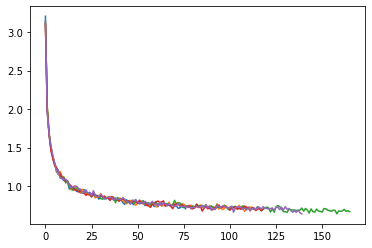

In [55]:
model_serch()

In [82]:
tf.random.set_seed(42)
# 모델 훈련
model1 = keras.models.Sequential()
model1 = Sequential([
    Dropout(0.1,input_shape=X_train.shape[1:]),
    Dense(128,activation="selu",kernel_initializer="lecun_normal"),
    Dropout(0.4),
    Dense(128, activation="selu",kernel_initializer="lecun_normal"),
    Dropout(0.4),
    Dense(61, activation = 'softmax')])
model1.compile(loss="sparse_categorical_crossentropy",  # 평가기준이 mape 이니까 이걸로 하자.
              optimizer=keras.optimizers.Adam())
early_stopping = keras.callbacks.EarlyStopping(patience=2,
                                               monitor = 'val_loss',
                                             restore_best_weights=True)
history1 = model1.fit(X_train, y_train,
                      callbacks = [early_stopping],
                      class_weight=di,
                      batch_size = 10,
                    epochs=1000,
                        validation_data=(X_val, y_val))

Train on 2500 samples, validate on 625 samples
Epoch 1/1000
2500/2500 [==============================] - 1s 262us/sample - loss: 2.7265 - val_loss: 1.4816
Epoch 2/1000
2500/2500 [==============================] - 0s 158us/sample - loss: 1.7662 - val_loss: 1.1748
Epoch 3/1000
2500/2500 [==============================] - 0s 115us/sample - loss: 1.5260 - val_loss: 1.0491
Epoch 4/1000
2500/2500 [==============================] - 0s 147us/sample - loss: 1.4226 - val_loss: 0.9818
Epoch 5/1000
2500/2500 [==============================] - 0s 156us/sample - loss: 1.3178 - val_loss: 0.9368
Epoch 6/1000
2500/2500 [==============================] - 0s 163us/sample - loss: 1.2437 - val_loss: 0.9025
Epoch 7/1000
2500/2500 [==============================] - 0s 162us/sample - loss: 1.1731 - val_loss: 0.8969
Epoch 8/1000
2500/2500 [==============================] - 0s 132us/sample - loss: 1.1777 - val_loss: 0.8396
Epoch 9/1000
2500/2500 [==============================] - 0s 124us/sample - loss: 1.0977 

In [59]:
tf.random.set_seed(42)

# 모델 훈련
model1 = keras.models.Sequential()
model1 = Sequential([
    Dropout(0.1,input_shape=X_train.shape[1:]),
    Dense(128, kernel_initializer='he_normal', activation = "elu"),
    Dropout(0.4),
    Dense(128, kernel_initializer='he_normal', activation = "elu"),
    Dropout(0.4),
    Dense(61, activation = 'softmax')])

model1.compile(loss="sparse_categorical_crossentropy",  # 평가기준이 mape 이니까 이걸로 하자.
              optimizer=keras.optimizers.Adam())

early_stopping = keras.callbacks.EarlyStopping(patience=16,
                                               monitor = 'val_loss',
                                             restore_best_weights=True)

history1 = model1.fit(X_train, y_train,
                      callbacks = [early_stopping],
                      class_weight=di,
                      batch_size = 10,
                    epochs=1000,
                        validation_data=(X_val, y_val))

Train on 2500 samples, validate on 625 samples
Epoch 1/1000
2500/2500 [==============================] - 1s 289us/sample - loss: 3.1710 - val_loss: 1.6183
Epoch 2/1000
2500/2500 [==============================] - 0s 173us/sample - loss: 2.0462 - val_loss: 1.2707
Epoch 3/1000
2500/2500 [==============================] - 0s 176us/sample - loss: 1.7299 - val_loss: 1.1151
Epoch 4/1000
2500/2500 [==============================] - 0s 166us/sample - loss: 1.4960 - val_loss: 1.0334
Epoch 5/1000
2500/2500 [==============================] - 0s 160us/sample - loss: 1.4197 - val_loss: 0.9495
Epoch 6/1000
2500/2500 [==============================] - 0s 134us/sample - loss: 1.2891 - val_loss: 0.9429
Epoch 7/1000
2500/2500 [==============================] - 0s 138us/sample - loss: 1.2831 - val_loss: 0.8932
Epoch 8/1000
2500/2500 [==============================] - 0s 144us/sample - loss: 1.1780 - val_loss: 0.8616
Epoch 9/1000
2500/2500 [==============================] - 0s 137us/sample - loss: 1.1217 

In [134]:
# 모델 훈련
model2 = keras.models.Sequential()
model2 = Sequential([
    Dropout(0.3,input_shape=X_train.shape[1:]),
    Dense(128, activation = "relu"),
    Dropout(0.4),
    Dense(61, activation = 'softmax')])

model2.compile(loss="sparse_categorical_crossentropy",  # 평가기준이 mape 이니까 이걸로 하자.
              optimizer=keras.optimizers.Adam())

early_stopping = keras.callbacks.EarlyStopping(patience=64,
                                               monitor = 'val_loss',
                                             restore_best_weights=True)

history2 = model2.fit(X_train, y_train,
                      callbacks = [early_stopping],
                      batch_size = 10,
                        epochs=1000,
                        validation_data=(X_val, y_val))

Train on 2500 samples, validate on 625 samples
Epoch 1/1000
2500/2500 [==============================] - 1s 265us/sample - loss: 2.8572 - val_loss: 1.9799
Epoch 2/1000
2500/2500 [==============================] - 0s 114us/sample - loss: 1.9649 - val_loss: 1.5468
Epoch 3/1000
2500/2500 [==============================] - 0s 93us/sample - loss: 1.7269 - val_loss: 1.3288
Epoch 4/1000
2500/2500 [==============================] - 0s 138us/sample - loss: 1.5694 - val_loss: 1.1893
Epoch 5/1000
2500/2500 [==============================] - 0s 127us/sample - loss: 1.4567 - val_loss: 1.1019
Epoch 6/1000
2500/2500 [==============================] - 0s 99us/sample - loss: 1.3624 - val_loss: 1.0335
Epoch 7/1000
2500/2500 [==============================] - 0s 108us/sample - loss: 1.3303 - val_loss: 1.0028
Epoch 8/1000
2500/2500 [==============================] - 0s 120us/sample - loss: 1.3226 - val_loss: 0.9676
Epoch 9/1000
2500/2500 [==============================] - 0s 113us/sample - loss: 1.2478 - 

In [81]:
model1.(X_val)

array([26, 26, 26, 15,  6, 26, 26, 26, 54, 26, 18, 28, 26, 26, 41, 26,  8,
        8, 60, 21, 36, 26, 26,  1, 49, 46, 26, 26, 50, 26, 26, 26, 26, 27,
       44, 26, 19, 26, 26, 26, 26, 26,  8, 26, 26, 26, 26,  4, 14, 26, 11,
       11, 26, 26, 27, 26, 26, 26, 30, 19, 24, 26, 55, 26, 26, 37, 28, 18,
       26, 30, 26, 18, 26, 26, 26, 56, 26, 26, 54, 27, 43, 26, 57, 20, 26,
       36, 11,  3, 25,  9, 26, 26, 25, 54, 26, 26, 17, 26, 56, 60, 26, 30,
       26, 26, 28, 26, 26, 45, 28, 26, 15, 26, 26, 26, 26, 26, 28, 26,  8,
       26, 26, 26, 52, 26, 26, 26, 26, 26, 55, 26,  8,  6,  7, 26, 21,  8,
       50, 12, 26, 26, 26, 51, 26, 40, 35, 37, 26, 55, 26, 26, 26, 59, 26,
       55, 26, 26, 26, 26, 34, 26, 41, 28, 26, 26, 26, 44, 26, 26, 26, 26,
       51,  7, 26, 26, 44, 50, 26,  4, 26, 42, 26, 26, 26, 26,  4, 26, 26,
       26,  9, 26, 47, 26, 26, 47, 40, 26, 21, 17, 26, 14, 28, 26, 26, 17,
       26,  8, 55, 26, 26, 38, 43, 26, 26, 26, 26, 26, 26, 26, 26,  4, 26,
       26,  7, 26, 26, 26

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

q = pd.DataFrame(range(0,61),columns=['label'])
idx = np.array(pd.merge(q,train_labels[['label','label_desc']],on='label').drop_duplicates()['label_desc'])
class_name = idx
print( classification_report(y_val,model1.predict_classes(X_val),target_names= class_name ) )

                                                          precision    recall  f1-score   support

                                     Arm Band Adjustment       0.50      0.50      0.50         2
                                      Band Pull-Down Row       1.00      0.75      0.86         4
                                              Bicep Curl       0.00      0.00      0.00         4
                                      Biceps Curl (band)       0.40      0.40      0.40         5
                                                  Burpee       0.67      0.86      0.75         7
                                        Butterfly Sit-up       0.62      1.00      0.77         5
                                      Chest Press (rack)       0.50      0.60      0.55         5
                                                  Crunch       1.00      0.80      0.89         5
                                         Device on Table       0.95      0.90      0.92        20
                   

In [55]:
confusion= pd.DataFrame(confusion_matrix(y_val, model.predict(X_val)),columns = idx)

NameError: name 'model' is not defined

In [ ]:
confusion.index = idx

In [56]:
confusion

NameError: name 'confusion' is not defined

# 제출

## 최종 Upsampling

In [56]:
#from imblearn.over_sampling import ADASYN
#from imblearn.over_sampling import RandomOverSampler
#X_samp, y_samp = ADASYN(random_state=0,sampling_strategy=dic).fit_sample(X, y)

## Test set 변환

In [57]:
df_,df_test,df_test1,df_test2 = moving(test)

In [58]:
df_ = Local(df_,df_test2)
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0


In [59]:
df_ = Diff(df_,df_test1)
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559


In [60]:
df_ = Mean(df_,df_test1)
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390


In [61]:
df_ = Dif_Mean(df_,test)

In [62]:
df_

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210,113.142606,41.386256,88.823479,6046.788273,14737.667332,5482.327105
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763,261.461048,170.438811,193.943447,22237.065864,19665.103823,28645.786660
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994,62.137478,95.347372,75.285231,9846.892109,5245.916651,9622.727946
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192,238.343292,116.581230,161.187822,13120.961915,15337.533189,12864.493877
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607,136.852763,151.217840,130.793046,36507.132971,28744.872301,18966.648874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174,133.976094,136.842298,92.716036,54293.615806,31259.778435,28319.951771
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080,299.704804,186.121960,109.384173,37256.934439,25434.719080,39222.971173
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260,122.708753,156.263383,132.447290,16619.493762,14271.650146,18639.216142
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390,83.472363,56.760531,84.841468,15309.347190,21302.401369,13572.810095


In [63]:
Big(df_,test)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210,113.142606,41.386256,88.823479,6046.788273,14737.667332,5482.327105,42.0
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763,261.461048,170.438811,193.943447,22237.065864,19665.103823,28645.786660,20.0
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994,62.137478,95.347372,75.285231,9846.892109,5245.916651,9622.727946,23.0
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192,238.343292,116.581230,161.187822,13120.961915,15337.533189,12864.493877,2.0
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607,136.852763,151.217840,130.793046,36507.132971,28744.872301,18966.648874,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174,133.976094,136.842298,92.716036,54293.615806,31259.778435,28319.951771,31.0
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080,299.704804,186.121960,109.384173,37256.934439,25434.719080,39222.971173,23.0
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260,122.708753,156.263383,132.447290,16619.493762,14271.650146,18639.216142,10.0
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390,83.472363,56.760531,84.841468,15309.347190,21302.401369,13572.810095,60.0


In [65]:
bet(df_,test)

,noise_acc_x,noise_acc_y,noise_acc_z,noise_gy_x,noise_gy_y,noise_gy_z,local_acc_x,local_acc_y,local_acc_z,local_gy_x,local_gy_y,local_gy_z,dif_acc_x,dif_acc_y,dif_acc_z,dif_gy_x,dif_gy_y,dif_gy_z,mean_acc_x,mean_acc_y,mean_acc_z,dif_mean_acc_x,dif_mean_acc_y,dif_mean_acc_z,dif_mean_gy_x,dif_mean_gy_y,dif_mean_gy_z,big,bet_gy_x,bet_gy_y,bet_gy_z
0,103.443727,152.399926,110.633155,146.225813,105.267515,104.871208,29.0,71.0,14.0,76.0,10.0,19.0,1.238118,0.590079,0.709008,84.895278,171.149042,80.255480,-1.019356,-0.019195,-0.233210,113.142606,41.386256,88.823479,6046.788273,14737.667332,5482.327105,42.0,187.0,115.0,232.0
1,36.452674,66.451195,31.310371,101.654960,76.669291,70.050272,13.0,24.0,19.0,19.0,16.0,12.0,2.172011,1.751576,1.555044,372.603348,311.911508,313.693212,-0.523168,0.610759,-0.070763,261.461048,170.438811,193.943447,22237.065864,19665.103823,28645.786660,20.0,48.0,85.0,48.0
2,178.598511,89.573358,73.162080,110.884419,134.943854,136.203925,50.0,41.0,32.0,32.0,37.0,23.0,2.822718,1.255271,0.883553,227.708767,151.695240,224.844549,0.506954,0.903966,-0.140994,62.137478,95.347372,75.285231,9846.892109,5245.916651,9622.727946,23.0,117.0,223.0,115.0
3,20.125753,27.224241,17.309542,156.539291,92.334863,95.833209,17.0,23.0,21.0,24.0,10.0,10.0,1.348216,0.969437,1.169263,341.240853,283.540908,282.097175,-0.576289,-0.611267,0.032192,238.343292,116.581230,161.187822,13120.961915,15337.533189,12864.493877,2.0,223.0,211.0,201.0
4,107.638975,86.104446,74.982720,141.932183,115.434813,119.718000,35.0,38.0,28.0,32.0,22.0,27.0,1.629312,1.885360,1.519058,669.200145,438.325355,254.475745,-0.739660,0.182189,0.400607,136.852763,151.217840,130.793046,36507.132971,28744.872301,18966.648874,32.0,58.0,92.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,156.812649,146.388248,118.621095,162.534717,102.178606,110.881004,41.0,43.0,32.0,26.0,16.0,19.0,2.154180,3.426526,1.488343,1332.525922,415.079994,451.484385,-0.909197,0.486886,-0.238174,133.976094,136.842298,92.716036,54293.615806,31259.778435,28319.951771,31.0,29.0,35.0,55.0
778,64.493962,91.453967,121.484417,104.481811,101.855842,88.917450,30.0,27.0,21.0,23.0,14.0,11.0,3.084106,2.534085,1.570273,638.280804,414.250454,397.864937,-0.612035,0.370271,-0.108080,299.704804,186.121960,109.384173,37256.934439,25434.719080,39222.971173,23.0,39.0,47.0,33.0
779,69.684258,52.444999,47.272767,104.314210,106.932561,102.342289,28.0,23.0,23.0,32.0,22.0,16.0,1.475043,1.497980,1.193010,368.136655,253.820712,393.096662,-0.752458,0.199790,0.312260,122.708753,156.263383,132.447290,16619.493762,14271.650146,18639.216142,10.0,166.0,143.0,131.0
780,96.833254,115.526519,103.745360,99.141690,78.821067,120.031935,40.0,66.0,39.0,24.0,12.0,16.0,0.716203,0.489123,0.703171,119.586779,174.070061,104.623559,0.958915,-0.320980,-0.356390,83.472363,56.760531,84.841468,15309.347190,21302.401369,13572.810095,60.0,51.0,46.0,72.0


## Scaling

In [66]:
df_ = scaler.transform(df_)

## 최종 FITTING (NN)

In [68]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

In [69]:
def NN_model():
    model = Sequential([
        Dropout(0.1,input_shape=X_train.shape[1:]),
        Dense(128, kernel_initializer='he_normal', activation = "elu"),
        Dropout(0.4),
        Dense(128, kernel_initializer='he_normal', activation = "elu"),
        Dropout(0.4),
        Dense(61, activation = 'softmax')])
    model.compile(loss="sparse_categorical_crossentropy",  # 평가기준이 mape 이니까 이걸로 하자.
              optimizer=keras.optimizers.Adam())
    return model

0번째 모델 학습중
Train on 2500 samples, validate on 625 samples
Epoch 1/1000
2500/2500 [==============================] - 1s 293us/sample - loss: 3.2053 - val_loss: 1.5761
Epoch 2/1000
2500/2500 [==============================] - 0s 147us/sample - loss: 1.9804 - val_loss: 1.2365
Epoch 3/1000
2500/2500 [==============================] - 0s 151us/sample - loss: 1.6606 - val_loss: 1.0966
Epoch 4/1000
2500/2500 [==============================] - 0s 143us/sample - loss: 1.4799 - val_loss: 1.0067
Epoch 5/1000
2500/2500 [==============================] - 0s 170us/sample - loss: 1.3850 - val_loss: 0.9578
Epoch 6/1000
2500/2500 [==============================] - 0s 179us/sample - loss: 1.3004 - val_loss: 0.9110
Epoch 7/1000
2500/2500 [==============================] - 0s 178us/sample - loss: 1.1850 - val_loss: 0.8696
Epoch 8/1000
2500/2500 [==============================] - 0s 180us/sample - loss: 1.1549 - val_loss: 0.8428
Epoch 9/1000
2500/2500 [==============================] - 0s 153us/sample - lo

Epoch 73/1000
2500/2500 [==============================] - 0s 161us/sample - loss: 0.7615 - val_loss: 0.6510
Epoch 74/1000
2500/2500 [==============================] - 0s 169us/sample - loss: 0.7464 - val_loss: 0.6527
Epoch 75/1000
2500/2500 [==============================] - 0s 170us/sample - loss: 0.7710 - val_loss: 0.6388
Epoch 76/1000
2500/2500 [==============================] - 0s 170us/sample - loss: 0.7671 - val_loss: 0.6331
Epoch 77/1000
2500/2500 [==============================] - 0s 161us/sample - loss: 0.7448 - val_loss: 0.6477
Epoch 78/1000
2500/2500 [==============================] - 0s 144us/sample - loss: 0.7381 - val_loss: 0.6417
Epoch 79/1000
2500/2500 [==============================] - 0s 151us/sample - loss: 0.7241 - val_loss: 0.6531
Epoch 80/1000
2500/2500 [==============================] - 0s 155us/sample - loss: 0.7555 - val_loss: 0.6337
Epoch 81/1000
2500/2500 [==============================] - 0s 160us/sample - loss: 0.7264 - val_loss: 0.6136
Epoch 82/1000
2500/

2500/2500 [==============================] - 0s 162us/sample - loss: 0.7352 - val_loss: 0.6155
Epoch 110/1000
2500/2500 [==============================] - 0s 141us/sample - loss: 0.7030 - val_loss: 0.5859
Epoch 111/1000
2500/2500 [==============================] - 0s 146us/sample - loss: 0.7280 - val_loss: 0.6293
Epoch 112/1000
2500/2500 [==============================] - 0s 141us/sample - loss: 0.6949 - val_loss: 0.6088
Epoch 113/1000
2500/2500 [==============================] - 0s 138us/sample - loss: 0.7093 - val_loss: 0.6183
Epoch 114/1000
2500/2500 [==============================] - 0s 146us/sample - loss: 0.6979 - val_loss: 0.6134
Epoch 115/1000
2500/2500 [==============================] - 0s 139us/sample - loss: 0.7050 - val_loss: 0.6121
Epoch 116/1000
2500/2500 [==============================] - 0s 150us/sample - loss: 0.7325 - val_loss: 0.6254
Epoch 117/1000
2500/2500 [==============================] - 0s 146us/sample - loss: 0.7201 - val_loss: 0.6035
Epoch 118/1000
2500/2500 

2500/2500 [==============================] - 0s 129us/sample - loss: 0.6965 - val_loss: 0.7265
Epoch 93/1000
2500/2500 [==============================] - 0s 123us/sample - loss: 0.7261 - val_loss: 0.7152
Epoch 94/1000
2500/2500 [==============================] - 0s 151us/sample - loss: 0.7187 - val_loss: 0.7224
Epoch 95/1000
2500/2500 [==============================] - 0s 166us/sample - loss: 0.7565 - val_loss: 0.7094
Epoch 96/1000
2500/2500 [==============================] - 0s 170us/sample - loss: 0.7218 - val_loss: 0.7046
Epoch 97/1000
2500/2500 [==============================] - 0s 167us/sample - loss: 0.7250 - val_loss: 0.7092
Epoch 98/1000
2500/2500 [==============================] - 0s 147us/sample - loss: 0.7401 - val_loss: 0.6888
Epoch 99/1000
2500/2500 [==============================] - 0s 127us/sample - loss: 0.7281 - val_loss: 0.7054
Epoch 100/1000
2500/2500 [==============================] - 0s 128us/sample - loss: 0.7208 - val_loss: 0.7074
Epoch 101/1000
2500/2500 [======

Epoch 122/1000
2500/2500 [==============================] - 0s 151us/sample - loss: 0.7041 - val_loss: 0.6502
Epoch 123/1000
2500/2500 [==============================] - 0s 158us/sample - loss: 0.7080 - val_loss: 0.6727
Epoch 124/1000
2500/2500 [==============================] - 0s 128us/sample - loss: 0.7171 - val_loss: 0.6414
Epoch 125/1000
2500/2500 [==============================] - 0s 137us/sample - loss: 0.6853 - val_loss: 0.6385
Epoch 126/1000
2500/2500 [==============================] - 0s 167us/sample - loss: 0.7249 - val_loss: 0.6413
Epoch 127/1000
2500/2500 [==============================] - 0s 154us/sample - loss: 0.7297 - val_loss: 0.6519
Epoch 128/1000
2500/2500 [==============================] - 0s 181us/sample - loss: 0.6947 - val_loss: 0.6473
Epoch 129/1000
2500/2500 [==============================] - 0s 179us/sample - loss: 0.7266 - val_loss: 0.6426
Epoch 130/1000
2500/2500 [==============================] - 0s 182us/sample - loss: 0.6897 - val_loss: 0.6359
Epoch 131/

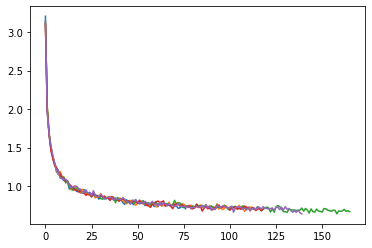

In [70]:
all_preds = []
idx = 0

for train_index, val_index in kf.split(X,y):
    tf.random.set_seed(42)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = NN_model()
    early_stopping = keras.callbacks.EarlyStopping(patience=32,
                                               monitor = 'val_loss',
                                             restore_best_weights=True)
    print(str(idx)+'번째 모델 학습중')
    history = model.fit(X_train, y_train,
                          callbacks = [early_stopping],
                          class_weight=di,
                          batch_size = 10,
                          epochs=1000,
                          validation_data=(X_val, y_val))
    idx+=1
    plt.plot(history.history['loss'], label='train' + str(idx))
    
    pred = model.predict_proba(df_)    
    all_preds.append(pred) # append 해야 각각이 구분되게 끊어져서 맞춰들어옴

In [71]:
prediction = np.mean(all_preds,axis=0)

In [72]:
prediction.shape

(782, 61)

In [73]:
submission.iloc[:,1:]=prediction

In [74]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000004,8.684204e-08,2.942339e-05,1.945481e-03,5.878661e-05,2.665778e-08,1.726236e-04,2.440731e-08,8.291162e-05,4.640754e-02,9.715404e-02,1.670125e-01,4.912916e-03,2.911027e-02,4.100653e-02,5.839844e-06,8.644844e-07,4.338206e-07,1.368439e-05,2.766855e-05,2.435999e-06,8.141253e-04,3.792996e-07,2.558916e-04,2.150831e-01,8.256892e-08,4.168705e-05,6.192748e-06,6.404799e-07,1.728617e-04,1.966055e-03,2.413742e-03,9.458745e-06,5.036578e-06,3.787625e-05,9.676977e-07,4.257194e-02,2.504960e-04,8.386023e-06,1.394262e-05,1.311618e-08,4.407797e-07,2.575655e-05,3.062386e-06,1.148569e-07,5.335000e-07,3.987728e-06,1.518478e-06,1.469038e-05,3.393146e-05,2.519790e-07,4.512586e-02,1.965072e-02,9.565559e-04,5.449919e-05,5.406299e-06,3.965892e-08,1.176139e-05,2.820485e-01,8.687773e-08,4.614378e-04
1,3126,0.002161,5.283865e-06,5.096355e-06,7.982615e-05,9.917374e-07,1.026478e-03,2.225945e-08,2.788738e-04,1.127561e-06,4.944891e-07,6.270599e-05,4.043520e-06,7.295287e-08,5.169778e-06,5.426751e-06,2.337462e-04,7.939188e-08,5.986915e-08,1.213296e-07,2.189915e-07,5.983898e-04,2.698774e-04,3.212325e-05,4.093383e-04,8.269731e-06,2.349154e-05,9.914986e-01,7.440402e-05,2.398772e-07,3.075105e-08,8.475009e-08,1.157366e-08,1.519705e-04,1.577664e-05,7.438742e-06,1.077159e-04,1.496687e-04,1.155713e-07,6.014320e-07,1.612224e-07,1.128159e-03,1.824546e-05,3.583444e-06,6.476022e-06,1.019382e-06,9.135633e-06,8.393592e-07,6.009221e-07,1.153505e-04,5.116026e-04,6.010706e-04,5.197966e-07,4.185177e-08,3.074723e-06,4.291649e-05,1.569782e-05,1.579270e-05,1.251145e-04,2.706595e-07,7.976702e-07,1.803313e-04
2,3127,0.018963,3.560177e-01,4.126987e-06,1.555907e-05,4.109711e-06,7.379687e-05,1.562481e-01,1.800590e-03,1.017184e-03,1.360534e-04,2.137802e-05,1.316261e-05,2.568763e-06,6.719505e-07,6.798438e-05,1.943652e-04,1.908682e-04,5.775194e-05,2.207240e-06,1.819768e-07,8.484153e-08,2.733868e-06,3.919993e-05,2.221396e-08,2.275219e-05,1.805249e-05,1.650448e-01,8.424544e-03,4.047375e-04,1.780987e-04,2.130784e-06,2.289325e-06,2.515764e-03,2.027274e-04,1.964464e-04,2.785649e-04,2.301846e-04,1.197107e-01,1.357423e-03,2.544720e-04,4.050483e-03,5.562595e-05,3.027965e-04,1.669814e-03,3.776204e-04,4.773990e-02,9.462159e-07,6.384945e-02,1.301090e-02,2.866132e-03,2.926948e-04,1.999327e-06,1.035840e-05,1.698134e-06,2.122759e-03,3.794314e-06,6.108762e-04,2.096255e-04,8.457658e-06,2.834628e-02,7.506277e-04
3,3128,0.000564,5.610118e-08,8.524519e-05,6.740190e-05,2.285584e-07,7.431790e-05,1.052846e-08,1.160992e-05,2.121128e-06,4.485531e-07,9.896306e-05,2.614502e-07,3.295719e-07,8.413674e-07,3.883951e-06,6.926490e-05,6.956935e-10,1.889041e-07,3.177595e-08,2.926726e-07,5.479321e-06,8.176497e-05,1.116921e-06,2.162324e-04,9.123755e-05,1.472882e-05,9.689662e-01,5.389741e-06,1.163099e-06,4.360302e-05,4.814170e-07,9.521337e-08,1.671108e-03,1.251045e-06,8.998323e-07,3.769467e-05,3.492342e-05,1.574840e-08,2.071828e-05,2.836026e-07,2.519973e-06,1.912869e-05,4.052672e-05,1.178035e-04,1.710797e-06,3.401777e-06,3.940169e-06,3.877934e-07,1.508755e-03,1.917994e-02,4.383844e-03,9.373123e-07,7.698397e-07,6.988618e-07,8.657882e-06,6.051819e-06,5.549168e-07,2.543916e-04,2.038286e-06,1.972356e-07,2.289475e-03
4,3129,0.005104,1.427271e-05,1.037329e-08,1.729753e-06,3.690358e-05,5.630753e-05,1.056261e-07,3.080708e-06,2.531225e-06,8.292052e-07,1.591978e-06,1.276206e-07,1.932718e-08,1.090072e-07,7.052159e-07,2.212953e-04,1.785038e-07,3.192340e-08,5.835781e-06,2.120067e-08,2.776169e-07,7.848062e-07,9.149587e-04,6.041393e-07,8.196536e-07,7.366260e-07,9.825918e-01,1.786931e-08,7.225216e-07,4.969104e-08,1.305957e-06,2.005823e-07,3.895091e-04,4.862016e-06,1.102777e-04,2.064357e-06,8.319704e-07,1.370488e-07,7.002731e-07,3.257599e-07,2.182063e-06,1.023359e-06,2.995215e-06,3.054370e-06,3.407347e-08,3.945756e-08,2.761628e-07,1.336794e-06,5.030825e-04

In [75]:
submission.to_csv('./Submission/hanadool_13_NN_kfold_weight.csv', index=False)